In [2]:
### Script to test using PCA instead of MOFA (to answer reviewer question only)

#############################################
# Prerequisites - Load Libraries

In [3]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/stark_stemi_R_Env_4_1//lib/R/library"



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
   

In [4]:
source('MS4_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


###############################################
# Preqrequisites Configurations & Parameters

In [7]:
data_path = '../data/current'

In [8]:
result_path = '../results/current'

In [9]:
data_path

[1] "../data/current"

In [10]:
name = 'V_FINAL_INTEGRATED'  # name of dataset to load

# Functions

In [11]:
### Function for quantile normalization

quantile_normalization = function(X){
  set.seed(42)
  ranks = apply(X, 2, rank, ties.method = 'min')  # determine ranks of each entry
  
  sorted = data.frame(apply(X, 2, sort)) # sort the entries
  means = apply(sorted, 1, mean) # calculate the means
  
  normalized_data = apply(ranks, 2 ,function(x){ means[x]}) # substitute the means into ranks matrix
}


In [12]:
### Gene wise quantile normalization

stdnorm <- function(x) {
  set.seed(42)
  r = rank(x[!is.na(x)], ties.method="average")
  x[!is.na(x)] = qnorm(r / (length(x[!is.na(x)]) + 1))
  return(x)
}

In [13]:
### Function to calculate mean difference between two groups

t_test_for_groups = function(heatmap_data, group1 = 'TP1|TP2', group2 = 'TP3|TP4', variable = 'measurement'){
    heatmap_data$group = NA
    heatmap_data$group[!is.na(str_extract(heatmap_data[,variable], group1))] = 'group1'
    heatmap_data$group[!is.na(str_extract(heatmap_data[,variable], group2))] = 'group2'
    
    t_test_result = heatmap_data %>% group_by(variable,view) %>% t_test(value~group)
    heatmap_data = merge(heatmap_data,t_test_result[,c('variable', 'view', 'p')])
    heatmap_data$variable[heatmap_data$p < 0.05/nrow(heatmap_data)] = paste0(heatmap_data$variable[heatmap_data$p < 0.05/nrow(heatmap_data)], '*')
    heatmap_data$gene[heatmap_data$p < 0.05/nrow(heatmap_data)] = paste0(heatmap_data$gene[heatmap_data$p < 0.05/nrow(heatmap_data)], '*')
    return(heatmap_data)
    }

# Load Data 

## Prepared combined data

In [14]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2024-01-03 14:26:41 CET"


In [15]:
#head(data_long,2)

In [16]:
data_long$X = NULL

## MOFA model weights for comparison

In [17]:
mofa_weights = read.csv(paste0(result_path, '/E-Analysis/', 'Weight_Data_V_FINAL_INTEGRATED_FALSE.csv'))

In [18]:
head(mofa_weights,10) # short check, correct weights

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,-0.134185974,0.40192217,-0.10107650,-0.002177566,-0.50936665,0.24179134,-0.036350975,0.05304519,0.0011574664,-0.0123071302,⋯,-0.160450518,-0.0014186183,0.154094465,0.003821864,-0.24205661,0.0040925822,-0.0005618720,-0.24239441,clinical_data,CK
2,-0.062226210,0.27319855,-0.20003621,-0.076098327,-0.14394453,0.04289833,-0.718185970,0.18658970,-0.0007753517,-0.0030743082,⋯,-0.610716171,0.0024994941,0.386446398,-0.001090137,-0.08311704,0.0095034985,-0.0003621744,0.20601583,clinical_data,CK_MB
3,-0.070745944,0.14369327,0.32511723,0.874486756,-0.62137315,-0.20316412,0.002131499,0.02329457,0.0041294886,0.0002250871,⋯,0.122925352,-0.0009936264,-0.756019708,-0.015343540,-0.09221061,-0.0051228455,0.0048858089,-0.40467127,clinical_data,CRP
4,-0.127869080,0.37564988,0.14888873,0.324815756,-0.57842721,0.04581684,-0.032055388,0.31853530,0.0142770231,-0.0049741087,⋯,-0.140620253,0.0065908149,0.128854858,-0.004313343,-0.14217673,-0.0004995215,0.0042891005,-0.46873354,clinical_data,Troponin
5,0.007978853,0.02443140,-0.01729291,-0.287106067,-0.06740164,-0.04226999,-0.034935911,0.02324887,-0.0958397941,-0.1544841783,⋯,0.661863941,0.5054456766,-0.051350948,0.039386175,-0.22319993,-0.0473087682,0.1148286132,-0.00669062,cytokine,BCA1__CXCL13
6,0.015216616,-0.17599838,0.02830920,-0.008525780,0.07248504,-0.05209972,-0.037116100,0.03559665,-0.2632141994,-0.0240123032,⋯,0.009363874,0.1033614366,-0.030655821,-0.062804961,0.03825064,-0.0388826053,0.1936810295,0.16105132,cytokine,CTACK__CCL27
7,0.013673086,0.07760928,0.30373924,-0.010782959,0.02232099,0.02009437,0.018305336,-0.06732902,-0.0948021288,-0.0010272207,⋯,0.068642082,-0.1331790555,0.009707243,-0.043243569,0.13468542,0.2209034400,-0.0852761492,-0.03313941,cytokine,EGF__EGF
8,0.020450195,-0.14861746,0.08744844,0.044758021,0.34629293,-0.05318961,-0.133780928,0.02442531,-0.0083637545,-0.0300759666,⋯,-0.016763253,0.0440043338,-0.002815433,-0.180605737,0.08039990,0.1188024393,-0.0096727341,0.08404169,cytokine,ENA78__CXCL5
9,-0.009040143,-0.10062609,-0.06195454,0.335670083,0.01772261,0.24874685,-0.070215374,0.02484327,-0.0308598353,0.1856367607,⋯,-0.092690643,0.1111322798,-0.023542523,0.023015143,1.18709314,0.1502934048,-0.2351307402,0.25937475,cytokine,Eotaxin__CCL11


## Sample Data

In [19]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

In [21]:
sample_data$CK_raw = sample_data$CK

In [22]:
sample_data$CK = log2(sample_data$CK+1)

In [23]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [24]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [25]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


# Train PCA

In [26]:
length(unique(data_long$variable))

[1] 13282

## Prepare data 

In [27]:
length(unique(data_long$sample_id))

[1] 128

In [28]:
final_data_long_backup = data_long

In [29]:
final_data_long = final_data_long_backup

In [32]:
#head(final_data_long,2)

In [33]:
unique(final_data_long$type)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
[5] "single_cell"

In [34]:
### Prepare data for PCA

In [35]:
final_data_long$variable_conc = paste0(final_data_long$type, '_0_', final_data_long$variable)

In [36]:
length(unique(final_data_long$variable_conc))

[1] 13282

In [38]:
#head(final_data_long,2)

In [39]:
##### convert to wide  format

final_data_wide = final_data_long %>% dcast(sample_id ~ variable_conc, value.vars = 'value')

In [40]:
nrow(final_data_wide)

[1] 128

In [41]:
rownames(final_data_wide) = final_data_wide$sample_id
final_data_wide$sample_id = NULL

In [42]:
final_data_wide = as.matrix(final_data_wide)

In [43]:
head(final_data_wide,2)

,clinical_data_0_CK,clinical_data_0_CK_MB,clinical_data_0_CRP,clinical_data_0_Troponin,cytokine_0_BCA1__CXCL13,cytokine_0_CTACK__CCL27,cytokine_0_EGF__EGF,cytokine_0_ENA78__CXCL5,cytokine_0_Eotaxin__CCL11,cytokine_0_Eotaxin2__CCL24,⋯,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZEB2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAND5,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFAS1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L1,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZFP36L2,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF106,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF207,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZNF706,single_cell_0_X9_Monocytes...CD16_FCGR3A__ZYX
k1,-2.397022,NA,-0.3186394,-1.286479,0.2902127,-0.08893463,1.5971323,2.414703,-0.2902127,0.04936312,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
k10,NA,NA,-0.8871466,NA,-0.9726875,-0.33164481,0.1685613,0.824864,1.0048676,0.97268746,⋯,0.6614351,-0.755415,-0.9345893,0.8416212,0.984235,0.6102946,0.8122178,-0.4537622,-0.115141,0.08365173


In [44]:
### No NA's in data input for PCA1

In [45]:
final_data_wide[is.na(final_data_wide)] = 0

## Run PCA

In [46]:
##### PCA result
set.seed(1)
pca_result = prcomp(final_data_wide, scale = FALSE)

In [47]:
str(pca_result)

List of 5
 $ sdev    : num [1:128] 27.1 24.1 20.5 17.3 17.2 ...
 $ rotation: num [1:13282, 1:128] 0.00847 0.00288 0.00511 0.00938 -0.00314 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:13282] "clinical_data_0_CK" "clinical_data_0_CK_MB" "clinical_data_0_CRP" "clinical_data_0_Troponin" ...
  .. ..$ : chr [1:128] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : Named num [1:13282] 1.39e-06 7.46e-05 8.15e-03 1.63e-02 1.08e-06 ...
  ..- attr(*, "names")= chr [1:13282] "clinical_data_0_CK" "clinical_data_0_CK_MB" "clinical_data_0_CRP" "clinical_data_0_Troponin" ...
 $ scale   : logi FALSE
 $ x       : num [1:128, 1:128] -0.11 -28.59 20.64 31.69 -2.85 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:128] "k1" "k10" "k11" "k12" ...
  .. ..$ : chr [1:128] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"


## Investigate PCA results

In [48]:
#### Investigate PCA result

In [49]:
head(pca_result$x, 2)   # similar to factor values of samples

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128
k1,-0.1104445,0.6202172,-0.164706,-0.9197066,0.0537092,-0.04918337,0.06440649,-0.3095937,0.2416664,-0.05027047,⋯,-6.350428,1.3846100,-6.2498614,9.30287982,-0.2348568,27.1264991,-1.7411090,0.1213044,-0.49687221,-7.946914e-15
k10,-28.5897884,-5.1728703,-10.329321,2.2854368,-31.3426413,-4.84044624,5.08258442,-16.6053067,-0.8571016,2.50684958,⋯,1.156287,-0.6817731,-0.2429447,0.05468426,-0.2056402,-0.1035651,0.1026742,-0.2108797,0.03312699,-4.035661e-14


In [50]:
factor_values = pca_result$x

In [51]:
weights = pca_result$rotation

In [52]:
head(weights,2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128
clinical_data_0_CK,0.008472125,0.016713433,0.006835005,-0.0003811446,0.006886444,-0.007398856,-0.0060602030,0.002797430,-0.002537761,0.018403093,⋯,0.03667011,0.04729318,0.03950562,-0.007325696,0.01255162,-0.070155411,-0.008536494,0.06603417,-0.019997847,0.03631375
clinical_data_0_CK_MB,0.002881206,0.008077372,0.007938372,0.0016851504,0.003544733,-0.001535679,0.0003993402,0.007402722,-0.006892604,0.009907261,⋯,0.03417031,0.04142949,0.03284893,0.016089608,0.04692741,0.008392392,-0.009462436,0.03839216,0.009774241,0.12247879


In [53]:
weights = as.data.frame(weights)

In [54]:
head(weights[order(abs(weights$PC2), decreasing = TRUE),],10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
single_cell_0_X2_T.cell.CD4__HIST1H4C,-0.0123064680,-0.02872549,-0.0004855385,-0.0058341657,-0.0116811338,0.007729126,0.0041593394,2.213658e-03,-0.010812100,0.004565492,⋯,7.029694e-06,0.0017780198,0.0019230718,8.341451e-04,0.0001752008,6.343350e-04,9.198682e-04,0.0001294380,-0.0019951347,0.0013154092
single_cell_0_X7_Monocytes...CD14__PLEKHO1,-0.0065201955,-0.02803340,0.0030826310,-0.0024227595,-0.0002987462,0.005406241,-0.0074700232,4.596053e-04,0.002962764,-0.001980755,⋯,2.411055e-03,-0.0001387147,0.0020862370,1.411734e-03,0.0009362546,5.525191e-05,-4.126249e-04,0.0011246492,-0.0012970260,-0.0051229977
single_cell_0_X0_T.cell.CD4__HINT1,0.0008502687,0.02801743,-0.0069488163,-0.0021663886,-0.0068340484,0.009889258,-0.0052815505,1.655016e-03,0.007318768,0.004757573,⋯,-1.620794e-04,-0.0011574681,-0.0016964823,8.965946e-05,0.0002399174,6.772077e-04,2.774626e-03,-0.0015191950,-0.0003404959,0.0010297734
single_cell_0_X4_Monocytes...CD14__CDC42,0.0036835778,0.02711562,-0.0088730009,-0.0024575533,-0.0013748786,0.003375352,-0.0026203020,-2.682892e-03,0.001802458,0.005254008,⋯,4.666186e-04,0.0002627265,0.0016783981,1.964278e-03,0.0007019030,5.096373e-04,-6.615235e-04,0.0003735952,-0.0007714081,-0.0020833052
single_cell_0_X7_Monocytes...CD14__CD74,-0.0070241427,-0.02678141,0.0043062677,0.0078473165,-0.0094883510,0.001445118,-0.0099260182,9.012783e-04,0.006521551,-0.009691269,⋯,1.119257e-03,0.0016117991,-0.0003652232,-1.304990e-03,-0.0007846324,-3.113925e-04,-3.850845e-05,0.0026679152,0.0011425944,0.0011541835
single_cell_0_X1_T.cell.CD8__TUBB4B,0.0114971158,-0.02659641,-0.0068510125,-0.0048360140,0.0058359651,-0.011940106,0.0090910708,1.768552e-02,-0.003943799,-0.007430087,⋯,1.928944e-03,0.0012005337,0.0009119478,1.409877e-03,0.0015523498,1.518874e-03,2.830608e-04,-0.0027279567,0.0002450027,-0.0060482293
single_cell_0_X4_Monocytes...CD14__PLEKHO1,-0.0107972016,-0.02644597,0.0025508138,0.0004407072,-0.0009092672,0.004294237,0.0132419791,5.643027e-05,0.004605855,0.002580265,⋯,2.531787e-03,-0.0009262857,-0.0007362133,9.057619e-04,-0.0001373244,-1.064806e-03,4.367757e-04,0.0020400089,-0.0012065181,0.0003847781
single_cell_0_X1_T.cell.CD8__HINT1,-0.0052787034,0.02639175,-0.0065933144,-0.0042763958,-0.0082264693,0.010207367,0.0006254185,1.409496e-02,-0.008483175,0.004369822,⋯,-1.166639e-03,-0.0034147897,-0.0012579811,3.536756e-04,-0.0004012513,-8.014426e-04,-1.176465e-03,-0.0001584632,0.0004475761,0.0049049951
single_cell_0_X0_T.cell.CD4__EIF3E,0.0057636727,0.02617636,-0.0024694559,-0.0003662178,0.0068355912,0.004483769,-0.0086743223,4.071213e-04,0.009963260,-0.010417314,⋯,2.490111e-03,-0.0014855977,-0.0006375564,1.596261e-03,-0.0004609245,-2.137907e-03,2.729725e-03,-0.0012769595,-0.0028538638,0.0032585153


In [55]:
### investigate some pca statistics

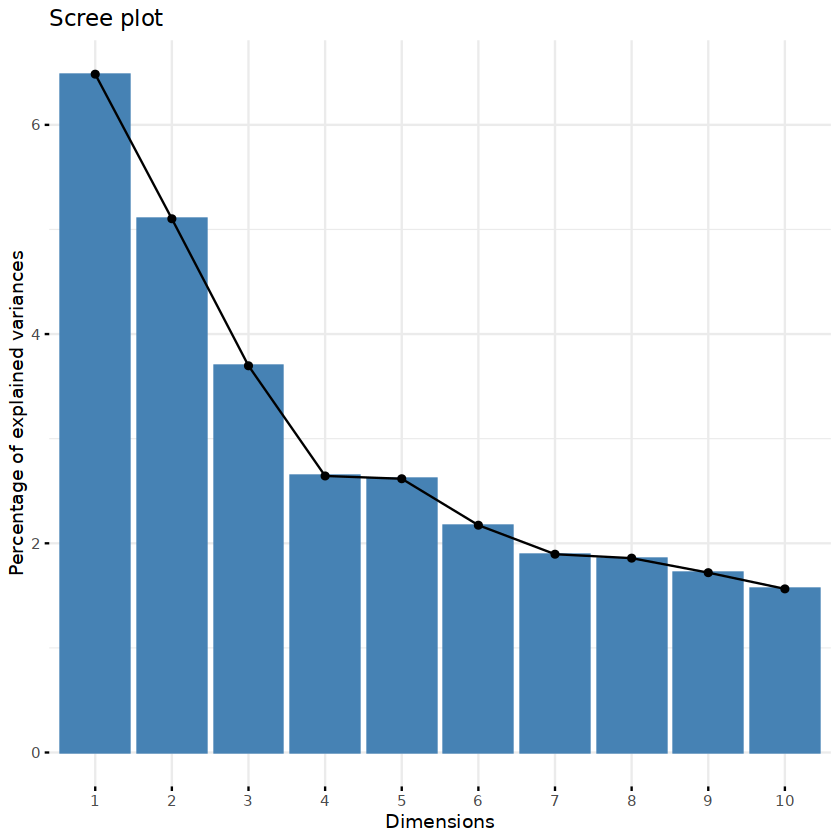

In [56]:
fviz_eig(pca_result)

# Downstream Analysis of PCA results

## Adjust sample data columns

In [57]:
sample_data$class = sample_data$group

In [58]:
sample_data$measurement2 = sample_data$measurement

In [59]:
sample_data$measurement2[sample_data$class %in% c('no_ccs', 'ccs')] = paste0(sample_data$measurement[sample_data$class %in% c('no_ccs', 'ccs')] , '_', sample_data$class[sample_data$class %in% c('no_ccs', 'ccs')])

In [60]:
sample_data$measurement_class =  paste0(sample_data$measurement , '_', sample_data$classification)

In [61]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [62]:
unique(sample_data$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP2_acs_subacute"              "TP3_acs_subacute"             
 [7] "TP4_acs_subacute"              "TP1_acs_w_infection"          
 [9] "TP2_acs_w_infection"           "TP3_acs_w_infection"          
[11] "TP4_acs_w_infection"           "TP1_acs_w_o_infection"        
[13] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[15] "TP4_acs_w_o_infection"

In [63]:
# Summarize good and intermediate outcome    
sample_data$delta_ef_value_class_summarized = sample_data$delta_ef_value_class
sample_data$delta_ef_value_class_summarized[sample_data$delta_ef_value_class %in% c('intermediate')] = 'good'

In [64]:
unique(sample_data$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

In [65]:
## Concatenate outcome with class

In [66]:
sample_data$tp_outcome = paste0(sample_data$measurement, '_', sample_data$delta_ef_value_class_summarized)

In [67]:
unique(sample_data$tp_outcome)

[1] "TP0_NA"   "TP1_NA"   "TP2_NA"   "TP3_NA"   "TP4_NA"   "TP1_bad" 
 [7] "TP2_bad"  "TP3_bad"  "TP4_bad"  "TP1_good" "TP2_good" "TP3_good"
[13] "TP4_good"

In [68]:
#head(sample_data,2)

## Extract data (for potential supplementary tables)

In [69]:
### Visualization of single factors

In [70]:
#### Extract factors and evaluate based on sample-data

In [71]:
factors = pca_result$x

In [72]:
head(factors,2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128
k1,-0.1104445,0.6202172,-0.164706,-0.9197066,0.0537092,-0.04918337,0.06440649,-0.3095937,0.2416664,-0.05027047,⋯,-6.350428,1.3846100,-6.2498614,9.30287982,-0.2348568,27.1264991,-1.7411090,0.1213044,-0.49687221,-7.946914e-15
k10,-28.5897884,-5.1728703,-10.329321,2.2854368,-31.3426413,-4.84044624,5.08258442,-16.6053067,-0.8571016,2.50684958,⋯,1.156287,-0.6817731,-0.2429447,0.05468426,-0.2056402,-0.1035651,0.1026742,-0.2108797,0.03312699,-4.035661e-14


In [73]:
factors = factors[,1:10]

In [74]:
factors = as.data.frame(factors)

In [75]:
factors$sample_id = rownames(factors)

## Merge factors and sample data

In [76]:
head(factors,2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,sample_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
k1,-0.1104445,0.6202172,-0.164706,-0.9197066,0.0537092,-0.04918337,0.06440649,-0.3095937,0.2416664,-0.05027047,k1
k10,-28.5897884,-5.1728703,-10.329321,2.2854368,-31.3426413,-4.84044624,5.08258442,-16.6053067,-0.8571016,2.50684958,k10


In [77]:
nrow(factors)

[1] 128

In [78]:
head(sample_data,2)

,X.1,sample_id,sample,id,measurement,library,id.y,name,read,pattern,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,k1,K1,1,TP0,L13,HTO_B0251,No-CCS-1,R2,5PNNNNNNNNNN(BC),⋯,NA,0.01863417,0.4854268,1,43,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,2,k10,K10,10,TP0,L11,HTO_B0256,Ch-CCS-10,R2,5PNNNNNNNNNN(BC),⋯,NA,NA,0.2630344,1,NA,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA


In [79]:
colnames(sample_data)

[1] "X.1"                             "sample_id"                      
 [3] "sample"                          "id"                             
 [5] "measurement"                     "library"                        
 [7] "id.y"                            "name"                           
 [9] "read"                            "pattern"                        
[11] "sequence"                        "feature_type"                   
[13] "X"                               "in_sample"                      
[15] "measurement_tp"                  "sc_rna_seq_data"                
[17] "age"                             "sex"                            
[19] "classification"                  "group"                          
[21] "meta_data"                       "delta_ef_value_group"           
[23] "delta_ef_value"                  "delta_ef_value_class"           
[25] "ef_classification_data"          "CK"                             
[27] "CK_MB"                           "Troponin"                       
[29] "CRP"                             "clinical_data"                  
[31] "CK_raw"                          "class"                          
[33] "measurement2"                    "measurement_class"              
[35] "delta_ef_value_class_summarized" "tp_outcome"

In [80]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [81]:
nrow(sample_data)

[1] 149

In [82]:
length(unique(sample_data$sample_id))

[1] 146

In [83]:
factors_merge = data.frame(factors)

In [84]:
factors_merge$sample_id = rownames(factors_merge)

In [85]:
merged_data = merge(factors_merge, sample_data, by.x = 'sample_id', by.y = 'sample_id')

In [87]:
#head(merged_data)

In [88]:
colnames(merged_data)

[1] "sample_id"                       "PC1"                            
 [3] "PC2"                             "PC3"                            
 [5] "PC4"                             "PC5"                            
 [7] "PC6"                             "PC7"                            
 [9] "PC8"                             "PC9"                            
[11] "PC10"                            "X.1"                            
[13] "sample"                          "id"                             
[15] "measurement"                     "library"                        
[17] "id.y"                            "name"                           
[19] "read"                            "pattern"                        
[21] "sequence"                        "feature_type"                   
[23] "X"                               "in_sample"                      
[25] "measurement_tp"                  "sc_rna_seq_data"                
[27] "age"                             "sex"                            
[29] "classification"                  "group"                          
[31] "meta_data"                       "delta_ef_value_group"           
[33] "delta_ef_value"                  "delta_ef_value_class"           
[35] "ef_classification_data"          "CK"                             
[37] "CK_MB"                           "Troponin"                       
[39] "CRP"                             "clinical_data"                  
[41] "CK_raw"                          "class"                          
[43] "measurement2"                    "measurement_class"              
[45] "delta_ef_value_class_summarized" "tp_outcome"

In [89]:
length(unique(merged_data$sample_id))

[1] 128

In [90]:
nrow(merged_data)

[1] 131

In [91]:
### Prepare long format and add necessary sample columns

In [92]:
merged_data$delta_ef_value = as.character(merged_data$delta_ef_value)

In [93]:
merged_data_long = melt(merged_data)

Using sample_id, sample, measurement, library, id.y, name, read, pattern, sequence, feature_type, X, measurement_tp, sex, classification, group, delta_ef_value_group, delta_ef_value, delta_ef_value_class, class, measurement2, measurement_class, delta_ef_value_class_summarized, tp_outcome as id variables



In [94]:
#head(merged_data_long,2)

In [95]:
merged_data_long = merged_data_long[!is.na(str_extract(merged_data_long$variable, 'PC')),]

In [96]:
colnames(merged_data_long)

[1] "sample_id"                       "sample"                         
 [3] "measurement"                     "library"                        
 [5] "id.y"                            "name"                           
 [7] "read"                            "pattern"                        
 [9] "sequence"                        "feature_type"                   
[11] "X"                               "measurement_tp"                 
[13] "sex"                             "classification"                 
[15] "group"                           "delta_ef_value_group"           
[17] "delta_ef_value"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "variable"                       
[25] "value"

In [97]:
unique(merged_data_long$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [98]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [99]:
unique(merged_data_long$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP1_acs_w_infection"           "TP2_acs_w_infection"          
 [7] "TP3_acs_w_infection"           "TP1_acs_w_o_infection"        
 [9] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[11] "TP4_acs_w_o_infection"         "TP4_acs_w_infection"          
[13] "TP2_acs_subacute"              "TP3_acs_subacute"             
[15] "TP4_acs_subacute"

In [100]:
merged_data_long$class_measurement = merged_data_long$group
merged_data_long$class_measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] =merged_data_long$measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] 

In [101]:
unique(merged_data_long$class_measurement)

[1] "no_ccs" "ccs"    "TP1"    "TP2"    "TP3"    "TP4"

## Visualize Factor Patterns (Boxplot/ Lineplot)

### All factors pattern visualization

In [102]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [103]:
merged_data_long$measurement_concat = merged_data_long$measurement

merged_data_long$measurement_concat[merged_data_long$measurement == 'TP0'] = paste0(merged_data_long$measurement[merged_data_long$measurement == 'TP0'], '_',
            merged_data_long$class[merged_data_long$measurement == 'TP0'])

In [104]:
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_no_ccs', 'No CCS')
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_ccs', 'CCS')

In [105]:
unique(merged_data_long$measurement_concat)

[1] "No CCS" "CCS"    "TP1"    "TP2"    "TP3"    "TP4"

In [106]:
figure_name = "SUPP2_PCA_Pattern_Time"

In [107]:
# Specific Text Descriptions:
xlabel = xlab('') 
ylabel = ylab('Factor Value')

In [108]:
# Sizes of the plot
width_par = 8.07
height_par = 3.5

png 
  2

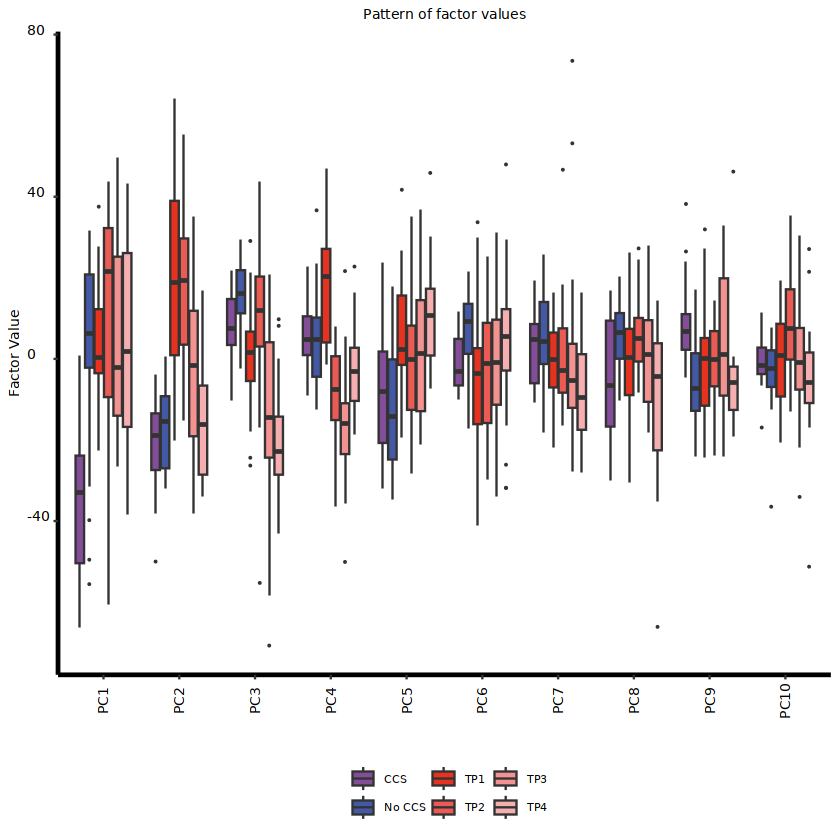

In [109]:
# grouped boxplot
#options(repr.plot.width=30, repr.plot.height=10)

vis_data = merged_data_long
g = ggplot(vis_data, aes(x=variable, y=value, fill = measurement_concat))  + 
    plot_config +
    xlabel + 
    ylabel +
    ccs_tp_fill +
    ggtitle('Pattern of factor values') + 
    theme(legend.position = "bottom", axis.text.x = element_text(angle = 90))+
    geom_boxplot(outlier.size = 0.05) 
#print(g)

pdf(paste0('figures/Supplementary_Figures/', figure_name,name,  '.pdf'), width =width_par, height =height_par)
print(g)
dev.off()
print(g)



# Compare weights MOFA / PCA

In [110]:
head(weights,2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
clinical_data_0_CK,0.008472125,0.016713433,0.006835005,-0.0003811446,0.006886444,-0.007398856,-0.0060602030,0.002797430,-0.002537761,0.018403093,⋯,0.03667011,0.04729318,0.03950562,-0.007325696,0.01255162,-0.070155411,-0.008536494,0.06603417,-0.019997847,0.03631375
clinical_data_0_CK_MB,0.002881206,0.008077372,0.007938372,0.0016851504,0.003544733,-0.001535679,0.0003993402,0.007402722,-0.006892604,0.009907261,⋯,0.03417031,0.04142949,0.03284893,0.016089608,0.04692741,0.008392392,-0.009462436,0.03839216,0.009774241,0.12247879


In [111]:
weights = weights[, 1:10]

In [112]:
head(mofa_weights,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,-0.13418597,0.4019222,-0.1010765,-0.002177566,-0.5093667,0.24179134,-0.03635097,0.05304519,0.0011574664,-0.012307130,⋯,-0.1604505,-0.001418618,0.1540945,0.003821864,-0.24205661,0.004092582,-0.0005618720,-0.2423944,clinical_data,CK
2,-0.06222621,0.2731985,-0.2000362,-0.076098327,-0.1439445,0.04289833,-0.71818597,0.18658970,-0.0007753517,-0.003074308,⋯,-0.6107162,0.002499494,0.3864464,-0.001090137,-0.08311704,0.009503498,-0.0003621744,0.2060158,clinical_data,CK_MB


In [113]:
mofa_weights = mofa_weights[, c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'type', 'variable_name')]

In [114]:
### Add columsn to PCA weights
weights$variable_name = rownames(weights)
weights$type = str_replace(weights$variable_name, '_0_.*', '')
weights$variable_name = str_replace(weights$variable_name, '.*_0_', '')

In [115]:
mofa_weights$type[!mofa_weights$type %in% c('clinical_data', 'cytokine', 'neutrophil', 'proteomics')] = 'single_cell'

In [116]:
unique(weights$type)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
[5] "single_cell"

In [117]:
unique(mofa_weights$type)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
[5] "single_cell"

In [118]:
nrow(mofa_weights)

[1] 13282

In [119]:
nrow(weights)

[1] 13282

In [120]:
weights_combined = merge(weights, mofa_weights)

In [121]:
nrow(weights_combined)

[1] 13282

In [122]:
head(weights_combined,2)

,variable_name,type,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Factor1,Factor2,Factor3,Factor4,Factor5
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG_M0R009,proteomics,-0.002542738,-0.006152053,-0.006278822,-0.007487850,-0.002180663,0.007206248,-0.004985433,0.001516472,0.005980696,-0.010945256,0.004658554,-0.078096205,0.06607495,0.13260059,0.0843015
2,A1BG_P04217.2,proteomics,-0.001817782,0.001536966,-0.005643651,-0.001861511,-0.004123412,0.005427317,0.004661701,-0.002682252,0.004409251,-0.008582449,0.001885317,-0.001767849,0.04799866,0.04030532,0.1117526


In [123]:
weights_combined_cor = weights_combined
weights_combined_cor$variable_name = NULL
weights_combined_cor$type = NULL

In [124]:
#weights_combined_cor = weights_combined_cor[, c('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5')]

In [125]:
head(weights_combined_cor,2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Factor1,Factor2,Factor3,Factor4,Factor5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.002542738,-0.006152053,-0.006278822,-0.007487850,-0.002180663,0.007206248,-0.004985433,0.001516472,0.005980696,-0.010945256,0.004658554,-0.078096205,0.06607495,0.13260059,0.0843015
2,-0.001817782,0.001536966,-0.005643651,-0.001861511,-0.004123412,0.005427317,0.004661701,-0.002682252,0.004409251,-0.008582449,0.001885317,-0.001767849,0.04799866,0.04030532,0.1117526


In [126]:
correlations = cor(weights_combined_cor,method = 'pearson', ,  use = "pairwise.complete.obs")
# correlation in slides: spearman, but nearly the same

In [127]:
#correlations

In [128]:
figure_name = "SUPP4_Correlation_Feature_Weight_Values_Mofa_vs_PCA"

In [129]:
# Sizes of the plot
width_par = 8
height_par = 3

In [130]:
correlations = correlations[,c('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10')]
correlations = correlations[c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'),]

In [131]:
head(correlations,2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Factor1,-0.97658246,0.03408187,-0.003552504,0.05592546,0.1232456,0.09638283,-0.05224423,-0.012404333,0.04435827,0.03182444
Factor2,0.08029459,0.97152755,0.027832272,0.05191436,0.1305815,0.07251827,-0.04714381,-0.002970664,-0.01557853,0.01670363


In [132]:
pdf(paste0('figures/Supplementary_Figures/', figure_name, name, '.pdf'), width =width_par, height =height_par)
correlation_plot = corrplot(correlations, method = 'number', title = '',  pch =20,  mar=c(0,0,2,0), number.cex = 0.8, tl.cex = 0.8, cl.cex =0.8)
dev.off()

png 
  2

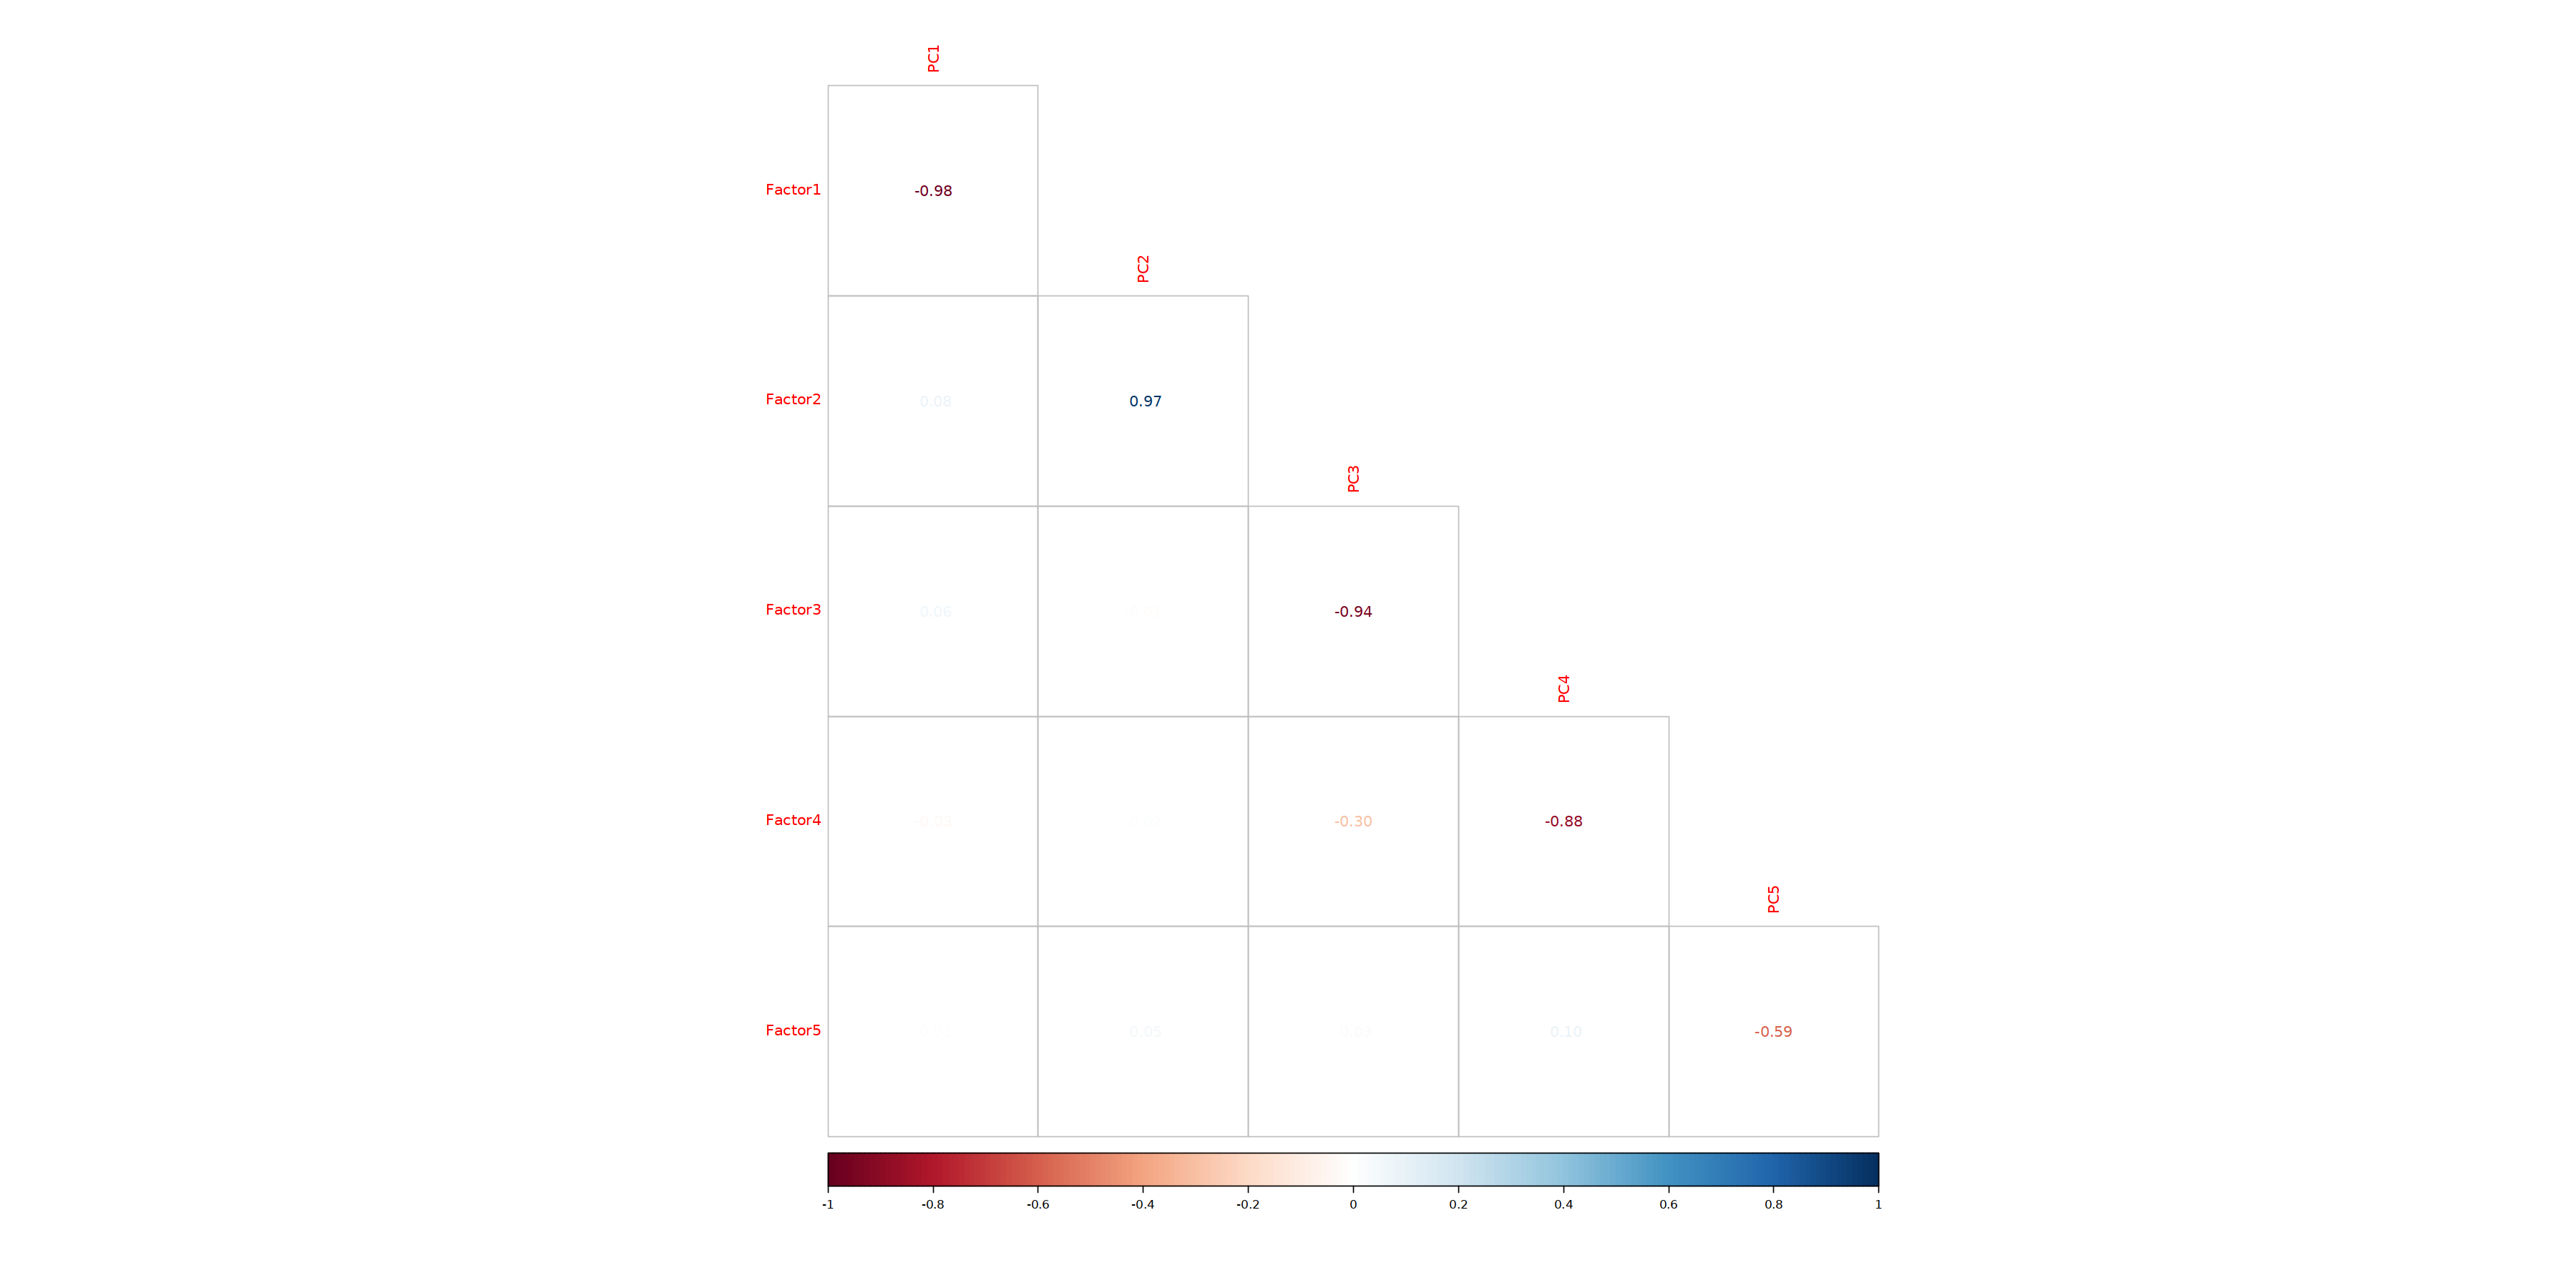

In [133]:
options(repr.plot.width=30, repr.plot.height=15)
corrplot(correlations, method = 'number',  type = 'lower')